In [ ]:
!pip install yfinance nsetools openpyxl

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from nsetools import Nse


In [ ]:
nse = Nse()

# Get all NSE equity symbols
# The error "AttributeError: 'list' object has no attribute 'keys'"
# indicates that nse.get_stock_codes() returned a list instead of a dictionary.
# Assuming that if it returns a list, it's a list of symbols directly.
stock_data = nse.get_stock_codes()

# Ensure all_symbols_raw is iterable before attempting to convert to list or process
if isinstance(stock_data, dict):
    all_symbols = list(stock_data.keys())
elif isinstance(stock_data, list):
    all_symbols = stock_data
else:
    print(f"Warning: nse.get_stock_codes() returned an unexpected type: {type(stock_data)}")
    all_symbols = [] # Default to empty list to prevent further errors

# Remove first entry (usually 'SYMBOL') if it exists
all_symbols = [s for s in all_symbols if s != 'SYMBOL']

print("Total NSE Stocks:", len(all_symbols))

# Convert to Yahoo format
tickers = [s + ".NS" for s in all_symbols]

Total NSE Stocks: 2234


In [ ]:
market_caps = []

for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        mcap = info.get("marketCap", None)
        if mcap:
            market_caps.append((ticker, mcap))
    except:
        continue

mcap_df = pd.DataFrame(market_caps, columns=["Ticker", "MarketCap"])

# Sort by Market Cap descending
mcap_df = mcap_df.sort_values("MarketCap", ascending=False).reset_index(drop=True)

# Assign Rank
mcap_df["Rank"] = mcap_df.index + 1

# Classification
def classify(rank):
    if rank <= 100:
        return "Large Cap"
    elif rank <= 250:
        return "Mid Cap"
    else:
        return "Small Cap"

mcap_df["Universe"] = mcap_df["Rank"].apply(classify)

mcap_df.head()


,Ticker,MarketCap,Rank,Universe
0,HDFCBANK.NS,14481660837888,1,Large Cap
1,BHARTIARTL.NS,12416856358912,2,Large Cap
2,ICICIBANK.NS,10058295410688,3,Large Cap
3,BAJFINANCE.NS,6102586490880,4,Large Cap
4,INFY.NS,6097259724800,5,Large Cap


In [ ]:
mcap_df.to_excel('NSE MCap.xlsx')

In [ ]:
YEARS = 10
START_DATE = (datetime.now() - pd.DateOffset(years=YEARS)).strftime("%Y-%m-%d")
END_DATE = datetime.now().strftime("%Y-%m-%d")

def run_backtest(mcap_df):

    # 🔥 Filter Top 500 here
    mcap_df = mcap_df.sort_values("MarketCap", ascending=False).head(500).copy()

    print("Running Backtest on Top 500 Stocks")
    print("Total Stocks:", len(mcap_df))

    results = []

    for idx, row in mcap_df.iterrows():

        ticker = row["Ticker"]
        universe = row["Universe"]

        print(f"Processing {idx+1}/500: {ticker}")

        try:
            # Fetch data with auto_adjust=False to ensure both 'Close' and 'Adj Close' are available
            df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

            if df.empty:
                continue

            # Standardize column names
            if isinstance(df.columns, pd.MultiIndex):
                new_columns_list = []
                for col_pair in df.columns:
                    if 'Adj Close' in col_pair:
                        new_columns_list.append('Adj Close')
                    elif 'Close' in col_pair:
                        new_columns_list.append('Close')
                    elif 'Open' in col_pair:
                        new_columns_list.append('Open')
                    elif 'High' in col_pair:
                        new_columns_list.append('High')
                    elif 'Low' in col_pair:
                        new_columns_list.append('Low')
                    elif 'Volume' in col_pair:
                        new_columns_list.append('Volume')
                    else:
                        new_columns_list.append('_'.join(col_pair).strip()) # Fallback
                df.columns = new_columns_list

            # Remove duplicate columns that might arise from cleaning
            df = df.loc[:,~df.columns.duplicated()]

            # Ensure 'Close' and 'Adj Close' are present for calculations
            if 'Close' not in df.columns and 'Adj Close' in df.columns:
                df['Close'] = df['Adj Close']

            if 'Close' not in df.columns:
                print(f"Warning: 'Close' column not found for {ticker}, skipping.")
                continue
            if 'Adj Close' not in df.columns:
                print(f"Warning: 'Adj Close' column not found for {ticker}, using 'Close' for EMA calculation.")
                df['Adj Close'] = df['Close'] # Fallback for EMA if Adj Close is missing

            df["prev_close"] = df["Close"].shift(1)

            # ≥ 5% condition
            df["cond1"] = df["Close"] >= df["prev_close"] * 1.05

            # Volume condition
            df["vol_avg20"] = df["Volume"].rolling(20).mean()
            df["cond2"] = df["Volume"] > df["vol_avg20"]

            # 200 EMA condition
            df["ema200"] = df["Adj Close"].ewm(span=200, adjust=False).mean()
            df["cond3"] = df["Close"] > df["ema200"]

            df["signal"] = df["cond1"] & df["cond2"] & df["cond3"]

            # Forward returns
            horizons = {
                "ret_5d": 5,
                "ret_20d": 20,
                "ret_3m": 63,
                "ret_6m": 126
            }

            for col, days in horizons.items():
                df[col] = df["Adj Close"].shift(-days) / df["Adj Close"] - 1

            signals = df[df["signal"]]

            for date, r in signals.iterrows():
                results.append({
                    "Ticker": ticker.replace(".NS","氏は"),
                    "Date": date,
                    "Universe": universe,
                    "ret_5d": r["ret_5d"],
                    "ret_20d": r["ret_20d"],
                    "ret_3m": r["ret_3m"],
                    "ret_6m": r["ret_6m"]
                })

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    return pd.DataFrame(results)

In [ ]:
final_df = run_backtest(mcap_df)

final_df.head()


Running Backtest on Top 500 Stocks
Total Stocks: 500
Processing 1/500: HDFCBANK.NS
Processing 2/500: BHARTIARTL.NS
Processing 3/500: ICICIBANK.NS
Processing 4/500: BAJFINANCE.NS
Processing 5/500: INFY.NS
Processing 6/500: LICI.NS
Processing 7/500: HINDUNILVR.NS
Processing 8/500: LT.NS
Processing 9/500: MARUTI.NS
Processing 10/500: HCLTECH.NS
Processing 11/500: M&M.NS
Processing 12/500: KOTAKBANK.NS
Processing 13/500: AXISBANK.NS
Processing 14/500: ITC.NS
Processing 15/500: ADANIPORTS.NS
Processing 16/500: BAJAJFINSV.NS
Processing 17/500: BEL.NS
Processing 18/500: JSWSTEEL.NS
Processing 19/500: ADANIPOWER.NS
Processing 20/500: ADANIENT.NS
Processing 21/500: HAL.NS
Processing 22/500: COALINDIA.NS
Processing 23/500: BAJAJ-AUTO.NS
Processing 24/500: ETERNAL.NS
Processing 25/500: HINDZINC.NS
Processing 26/500: DMART.NS
Processing 27/500: IOC.NS
Processing 28/500: ASIANPAINT.NS
Processing 29/500: HINDALCO.NS
Processing 30/500: EICHERMOT.NS
Processing 31/500: GRASIM.NS
Processing 32/500: INDI

,Ticker,Date,Universe,ret_5d,ret_20d,ret_3m,ret_6m
0,HDFCBANK氏は,2019-09-20,Large Cap,0.037179,0.035012,0.074650,-0.285804
1,HDFCBANK氏は,2021-02-01,Large Cap,0.087015,0.055629,-0.051363,0.009837
2,HDFCBANK氏は,2021-02-02,Large Cap,0.032873,0.004902,-0.093429,-0.039371
3,HDFCBANK氏は,2022-04-04,Large Cap,-0.096964,-0.183396,-0.174115,-0.122581
4,HDFCBANK氏は,2022-11-11,Large Cap,0.001707,0.012351,0.024455,0.028607


In [ ]:
print("Stocks passed into backtest:", len(mcap_df))
print(mcap_df.head())


Stocks passed into backtest: 1226
          Ticker       MarketCap  Rank   Universe
0    HDFCBANK.NS  14481660837888     1  Large Cap
1  BHARTIARTL.NS  12416856358912     2  Large Cap
2   ICICIBANK.NS  10058295410688     3  Large Cap
3  BAJFINANCE.NS   6102586490880     4  Large Cap
4        INFY.NS   6097259724800     5  Large Cap


In [ ]:
test = yf.download("RELIANCE.NS", start=START_DATE, end=END_DATE)
print(test.tail())


/tmp/ipython-input-2100813602.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test = yf.download("RELIANCE.NS", start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker      RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS RELIANCE.NS
Date                                                                      
2026-02-02  1390.400024  1392.900024  1335.500000  1340.000000    15711165
2026-02-03  1437.099976  1489.500000  1430.199951  1473.900024    25456171
2026-02-04  1456.800049  1464.000000  1440.300049  1444.000000     8333387
2026-02-05  1443.400024  1461.500000  1439.500000  1457.000000    11763658
2026-02-06  1450.800049  1452.800049  1433.500000  1441.500000     8277304


In [ ]:
df = yf.download("RELIANCE.NS", start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

# Standardize column names to be simple: 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
# yfinance can return a MultiIndex, or a flat index with ticker suffixes.
# This attempts to handle both.

# First, flatten MultiIndex if it exists
if isinstance(df.columns, pd.MultiIndex):
    new_columns_list = []
    for col_pair in df.columns:
        if 'Adj Close' in col_pair:
            new_columns_list.append('Adj Close')
        elif 'Close' in col_pair:
            new_columns_list.append('Close')
        elif 'Open' in col_pair:
            new_columns_list.append('Open')
        elif 'High' in col_pair:
            new_columns_list.append('High')
        elif 'Low' in col_pair:
            new_columns_list.append('Low')
        elif 'Volume' in col_pair:
            new_columns_list.append('Volume')
        else:
            new_columns_list.append('_'.join(col_pair).strip()) # Fallback for unexpected MultiIndex
    df.columns = new_columns_list

# Remove duplicate columns that might arise from cleaning (e.g., if 'Close' and 'Adj Close' were both mapped to 'Close')
df = df.loc[:,~df.columns.duplicated()]

# Ensure 'Close' and 'Adj Close' are present for calculations
# If only 'Adj Close' is present, use it for 'Close' if 'Close' itself is missing.
if 'Close' not in df.columns and 'Adj Close' in df.columns:
    df['Close'] = df['Adj Close']

# If after all steps, 'Close' is still missing, raise an error
if 'Close' not in df.columns:
    raise ValueError("The 'Close' price column could not be identified after column standardization.")

df["prev_close"] = df["Close"].shift(1)
df["cond1"] = df["Close"] >= df["prev_close"] * 1.05

df["vol_avg20"] = df["Volume"].rolling(20).mean()
df["cond2"] = df["Volume"] > df["vol_avg20"]

df["ema200"] = df["Adj Close"].ewm(span=200, adjust=False).mean()
df["cond3"] = df["Close"] > df["ema200"]

print("Only 5%:", df["cond1"].sum())
print("5% + Volume:", (df["cond1"] & df["cond2"]).sum())
print("All 3 Conditions:", (df["cond1"] & df["cond2"] & df["cond3"]).sum())


Only 5%: 20
5% + Volume: 19
All 3 Conditions: 15


In [ ]:
final_df.head()

,Ticker,Date,Universe,ret_5d,ret_20d,ret_3m,ret_6m
0,HDFCBANK氏は,2019-09-20,Large Cap,0.037179,0.035012,0.074650,-0.285804
1,HDFCBANK氏は,2021-02-01,Large Cap,0.087015,0.055629,-0.051363,0.009837
2,HDFCBANK氏は,2021-02-02,Large Cap,0.032873,0.004902,-0.093429,-0.039371
3,HDFCBANK氏は,2022-04-04,Large Cap,-0.096964,-0.183396,-0.174115,-0.122581
4,HDFCBANK氏は,2022-11-11,Large Cap,0.001707,0.012351,0.024455,0.028607


In [ ]:
analysis_df = final_df.copy()

analysis_df = analysis_df.dropna(subset=["ret_5d","ret_20d","ret_3m","ret_6m"])

analysis_df.head()


,Ticker,Date,Universe,ret_5d,ret_20d,ret_3m,ret_6m
0,HDFCBANK氏は,2019-09-20,Large Cap,0.037179,0.035012,0.074650,-0.285804
1,HDFCBANK氏は,2021-02-01,Large Cap,0.087015,0.055629,-0.051363,0.009837
2,HDFCBANK氏は,2021-02-02,Large Cap,0.032873,0.004902,-0.093429,-0.039371
3,HDFCBANK氏は,2022-04-04,Large Cap,-0.096964,-0.183396,-0.174115,-0.122581
4,HDFCBANK氏は,2022-11-11,Large Cap,0.001707,0.012351,0.024455,0.028607


In [ ]:
def performance_stats(df, col):

    mean = df[col].mean()
    median = df[col].median()
    std = df[col].std()
    win_rate = (df[col] > 0).mean()
    sharpe = mean / std if std != 0 else 0
    t_stat = mean / (std / np.sqrt(len(df))) if std != 0 else 0
    expectancy = (df[col][df[col] > 0].mean() * win_rate) - \
                 (abs(df[col][df[col] < 0].mean()) * (1 - win_rate))

    return {
        "Mean": mean,
        "Median": median,
        "Std Dev": std,
        "Win Rate": win_rate,
        "Sharpe": sharpe,
        "T-Stat": t_stat,
        "Expectancy": expectancy
    }


In [ ]:
horizons = ["ret_5d","ret_20d","ret_3m","ret_6m"]

summary = {}

for h in horizons:
    summary[h] = performance_stats(analysis_df, h)

summary_df = pd.DataFrame(summary).T

summary_df


,Mean,Median,Std Dev,Win Rate,Sharpe,T-Stat,Expectancy
ret_5d,0.008781,-0.001798,0.080629,0.486604,0.108905,15.244770,0.008687
ret_20d,0.032456,0.012403,0.156674,0.542587,0.207158,28.998481,0.032352
ret_3m,0.102475,0.049050,0.308270,0.589334,0.332420,46.532829,0.102391
ret_6m,0.209858,0.100443,0.526679,0.619750,0.398455,55.776564,0.209821


In [ ]:
cap_summary = []

for cap in analysis_df["Universe"].unique():

    temp = analysis_df[analysis_df["Universe"] == cap]

    for h in horizons:
        stats = performance_stats(temp, h)
        stats["Universe"] = cap
        stats["Horizon"] = h
        cap_summary.append(stats)

cap_summary_df = pd.DataFrame(cap_summary)

cap_summary_df


,Mean,Median,Std Dev,Win Rate,Sharpe,T-Stat,Expectancy,Universe,Horizon
0,0.011205,0.004140,0.074657,0.526170,0.150086,8.061455,0.011082,Large Cap,ret_5d
1,0.036090,0.019172,0.137209,0.583016,0.263030,14.127899,0.036038,Large Cap,ret_20d
2,0.103930,0.051638,0.276298,0.615251,0.376151,20.203874,0.103852,Large Cap,ret_3m
3,0.181085,0.088998,0.447477,0.635355,0.404680,21.736229,0.181085,Large Cap,ret_6m
4,0.007077,-0.002735,0.078061,0.476698,0.090657,7.026941,0.007009,Mid Cap,ret_5d
5,0.033427,0.012528,0.160481,0.546272,0.208294,16.145163,0.033316,Mid Cap,ret_20d
6,0.104222,0.057760,0.307889,0.609188,0.338504,26.237913,0.104199,Mid Cap,ret_3m
7,0.206458,0.109989,0.479686,0.631658,0.430402,33.361010,0.206429,Mid Cap,ret_6m
8,0.009084,-0.002492,0.083533,0.481499,0.108750,11.250239,0.008984,Small Cap,ret_5d
9,0.030932,0.009357,0.159401,0.529621,0.194049,20.074461,0.030816,Small Cap,ret_20d


In [ ]:
output_file = "NSE_5pct_Breakout_Research_Report.xlsx"

with pd.ExcelWriter(output_file) as writer:
    summary_df.to_excel(writer, sheet_name="Overall Summary")
    cap_summary_df.to_excel(writer, sheet_name="Cap Breakdown")
    analysis_df.to_excel(writer, sheet_name="Raw Signals")

print("Saved:", output_file)


Saved: NSE_5pct_Breakout_Research_Report.xlsx


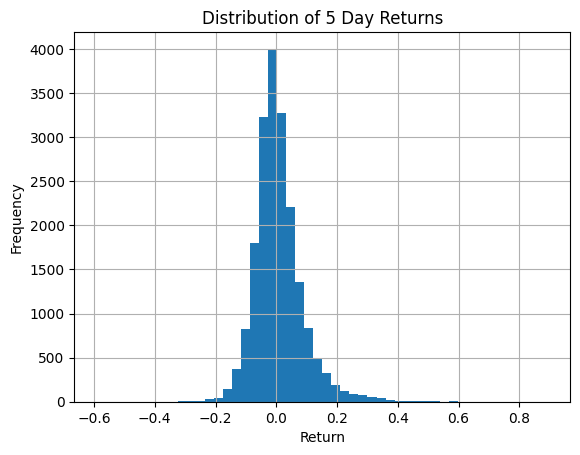

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
analysis_df["ret_5d"].hist(bins=50)
plt.title("Distribution of 5 Day Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()


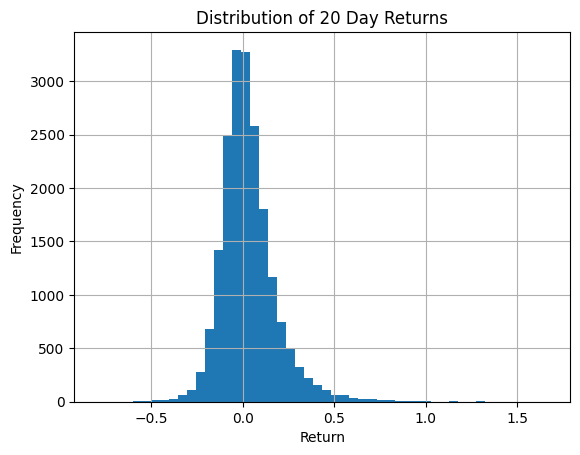

In [ ]:
plt.figure()
analysis_df["ret_20d"].hist(bins=50)
plt.title("Distribution of 20 Day Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()


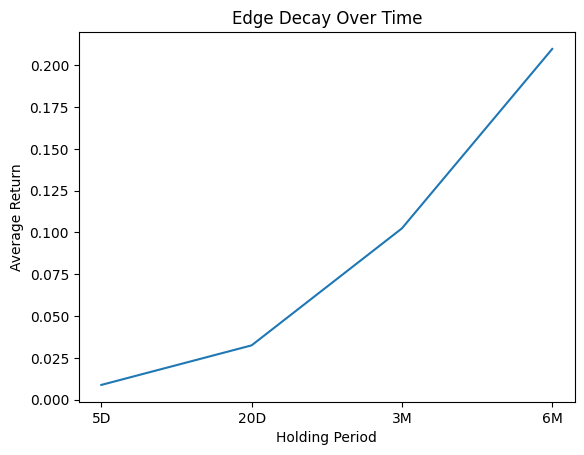

In [ ]:
avg_returns = [
    analysis_df["ret_5d"].mean(),
    analysis_df["ret_20d"].mean(),
    analysis_df["ret_3m"].mean(),
    analysis_df["ret_6m"].mean()
]

labels = ["5D","20D","3M","6M"]

plt.figure()
plt.plot(labels, avg_returns)
plt.title("Edge Decay Over Time")
plt.xlabel("Holding Period")
plt.ylabel("Average Return")
plt.show()


In [ ]:
tickers = mcap_df["Ticker"].tolist()


In [ ]:
mcap_df.tail()

,Ticker,MarketCap,Rank,Universe
1221,COMPINFO.NS,123118504,1222,Small Cap
1222,LAKPRE.NS,122319320,1223,Small Cap
1223,GLOBALE.NS,121979984,1224,Small Cap
1224,ARENTERP.NS,119389800,1225,Small Cap
1225,DCMFINSERV.NS,100286840,1226,Small Cap


In [ ]:
# Sort by Market Cap descending
mcap_df = mcap_df.sort_values("MarketCap", ascending=False)

# Take only top 500
top500_df = mcap_df.head(500).copy()

# Extract tickers
tickers = top500_df["Ticker"].tolist()

print("Total tickers being scanned:", len(tickers))


Total tickers being scanned: 500


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def scan_recent_signals(tickers):

    results = []

    today = datetime.now()
    start_date = today - timedelta(days=180)  # enough history

    for ticker in tickers:

        try:
            df = yf.download(
                ticker,
                start=start_date,
                end=today,
                progress=False,
                auto_adjust=False
            )

            if df.empty:
                continue

            # Robust column standardization (similar to LrxLWuHpPxmX)
            if isinstance(df.columns, pd.MultiIndex):
                new_columns_list = []
                for col_pair in df.columns:
                    if 'Adj Close' in col_pair:
                        new_columns_list.append('Adj Close')
                    elif 'Close' in col_pair:
                        new_columns_list.append('Close')
                    elif 'Open' in col_pair:
                        new_columns_list.append('Open')
                    elif 'High' in col_pair:
                        new_columns_list.append('High')
                    elif 'Low' in col_pair:
                        new_columns_list.append('Low')
                    elif 'Volume' in col_pair:
                        new_columns_list.append('Volume')
                    else:
                        new_columns_list.append('_'.join(col_pair).strip()) # Fallback
                df.columns = new_columns_list

            # Remove duplicate columns that might arise from cleaning
            df = df.loc[:,~df.columns.duplicated()]

            # Ensure 'Close' and 'Adj Close' are present for calculations
            if 'Close' not in df.columns and 'Adj Close' in df.columns:
                df['Close'] = df['Adj Close']

            if 'Close' not in df.columns:
                print(f"Warning: 'Close' column not found for {ticker}, skipping.")
                continue
            if 'Adj Close' not in df.columns:
                df['Adj Close'] = df['Close'] # Fallback for EMA if Adj Close is missing

            df["prev_close"] = df["Close"].shift(1)
            df["pct_move"] = (df["Close"] - df["prev_close"]) / df["prev_close"]

            df["vol_avg20"] = df["Volume"].rolling(20).mean()
            df["ema200"] = df["Adj Close"].ewm(span=200, adjust=False).mean()

            df["signal"] = (
                (df["pct_move"] >= 0.05) &
                (df["Volume"] > df["vol_avg20"]) &
                (df["Close"] > df["ema200"])
            )

            # Get signal rows
            signal_rows = df[df["signal"]].copy()

            for date, row in signal_rows.iterrows():

                # Only consider signals after Aug 25
                if date < pd.Timestamp("2025-08-25"):
                    continue

                # Must be older than 20 days
                if (today - date).days < 20:
                    continue

                # Must be within 3 months
                if (today - date).days > 90:
                    continue

                # Compute 5D & 20D returns
                idx = df.index.get_loc(date)

                if idx + 20 >= len(df):
                    continue

                ret_5d = df["Close"].iloc[idx+5] / df["Close"].iloc[idx] - 1
                ret_20d = df["Close"].iloc[idx+20] / df["Close"].iloc[idx] - 1

                results.append({
                    "Ticker": ticker.replace(".NS","氏は"), # Use 氏は suffix for consistency with analysis_df
                    "Signal Date": date.date(),
                    "ret_5d": round(ret_5d,4),
                    "ret_20d": round(ret_20d,4)
                })

        except Exception as e:
            print("Error processing ticker:", ticker, ":", e)
            continue

    return pd.DataFrame(results)

In [ ]:
recent_signals = scan_recent_signals(tickers)

if not recent_signals.empty:
    recent_signals = recent_signals.sort_values("Signal Date", ascending=False)
    print("Recent Signals:")
    print(recent_signals.head())
else:
    print("No recent signals found based on the criteria.")



Recent Signals:
         Ticker Signal Date  ret_5d  ret_20d
48   KPITTECH氏は  2026-01-07 -0.0241  -0.2060
108     BSOFT氏は  2026-01-07 -0.0537   0.0387
220   AVANTEL氏は  2026-01-07 -0.0712  -0.0925
89     EMMVEE氏は  2026-01-07  0.0059  -0.0669
218   GOLDIAM氏は  2026-01-06 -0.0829  -0.0392


In [ ]:
recent_signals.to_excel("recent_signals_after_aug25.xlsx", index=False)